In [1]:

import shutil
import gc

# synthetic data
from datetime import datetime
from PIL import Image
import os, os.path
import torchvision.transforms.functional as TF
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import torch
import math
import sys
from skimage.transform import rescale, resize, downscale_local_mean
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import numpy as np
from sklearn import model_selection
import torch.optim.lr_scheduler as Lrate
import random
from random import randrange
import fnmatch
import cv2
import openslide

# Check the dimensions tile predictions for TIL, stroma and Tumor

In [2]:
input_path="../shared_bucket/datasets/VanAbel_Oropharynx/"
h_path='hxu_predictions-Jinhwan/pred_tils/'
tils_hm_files = fnmatch.filter(os.listdir(input_path+'Van Abel-K_req32469_OPX TILs HE/'), '*LN*.svs')
tis_img_files=fnmatch.filter(os.listdir(h_path), '*LN*'+'*gray*.png')
coord_path='CSV_coordinates_heatmap_LN/'
tis_img_files.sort()
#print(tis_img_files)
tils_hm_files.sort()
i=0
Tile_size=[112,112]
for (tils_file,img_file) in zip(tils_hm_files,tis_img_files) :
    print(tils_file,img_file)
    i+=1
    HE_file=input_path+'Van Abel-K_req32469_OPX TILs HE/'+tils_file
    h_file=h_path+img_file
    print(h_file)
    Slide = openslide.OpenSlide(HE_file)
    xr = float(Slide.properties['openslide.mpp-x'])  # pixel resolution at x direction
    yr = float(Slide.properties['openslide.mpp-y'])  # pixel resolution at y direction
    Dims = Slide.level_dimensions
    Stride = [round(Tile_size[0] / xr), round(Tile_size[1] / yr)]
    #print(Stride)
    X = np.arange(0, Dims[0][0] + 1, Stride[0])
    Y = np.arange(0, Dims[0][1] + 1, Stride[1])
    #print(X.shape,Y.shape)
    X, Y = np.meshgrid(X, Y)
    img=plt.imread(h_file)
    print(X.shape,Y.shape)
    with open(coord_path+img_file.split('_')[0]+'_coord_files.csv', 'w') as outfile :
        outfile.write('index_x,index_y,WSI_x, WSI_y, til_score\n')
        for i in range(X.shape[0] - 1):
            for j in range(X.shape[1] - 1):
                score=img[i,j]
                
                outfile.write(str(i)
                      + ',' + str(j)
                      + ',' + str(X[i,j])+','+str(Y[i,j]) + ','+str(score[0])+'\n')
    

        

1664369_MR16-1693 I4_LN_HE.svs 1664369_MR16-1693 I4_LN_HE_gray.png
hxu_predictions-Jinhwan/pred_tils/1664369_MR16-1693 I4_LN_HE_gray.png
(191, 342) (191, 342)
2305194_CR12-4869 K7_LN_HE.svs 2305194_CR12-4869 K7_LN_HE_gray.png
hxu_predictions-Jinhwan/pred_tils/2305194_CR12-4869 K7_LN_HE_gray.png
(192, 237) (192, 237)
2332894_CR10-3906 L6_LN_HE.svs 2332894_CR10-3906 L6_LN_HE_gray.png
hxu_predictions-Jinhwan/pred_tils/2332894_CR10-3906 L6_LN_HE_gray.png
(178, 229) (178, 229)
2339093_MR13-3004 G4_LN_HE.svs 2339093_MR13-3004 G4_LN_HE_gray.png
hxu_predictions-Jinhwan/pred_tils/2339093_MR13-3004 G4_LN_HE_gray.png
(203, 308) (203, 308)
2369433_CR09-3283 D11_LN_HE.svs 2369433_CR09-3283 D11_LN_HE_gray.png
hxu_predictions-Jinhwan/pred_tils/2369433_CR09-3283 D11_LN_HE_gray.png
(186, 298) (186, 298)
2747756_CR10-1140 E6_LN_HE.svs 2747756_CR10-1140 E6_LN_HE_gray.png
hxu_predictions-Jinhwan/pred_tils/2747756_CR10-1140 E6_LN_HE_gray.png
(199, 327) (199, 327)
2991376_CR09-1508 A18_LN_HE.svs 2991376_CR0

# Following function computed density of TILs in various regions of the tissue in grids on the predicted tiles

In [375]:
def tils_density(input_path):
    tils_hm_files = fnmatch.filter(os.listdir(input_path+'pred_tils/'), '*Tumor*_gray.png')
    tils_hm_files.sort()
    
    M=17; N=17
    with open('result_Tumor_tils_density_test.csv', 'a') as outfile :
        outfile.write('file_name,immune_infl,immune_excl,immune_des\n')
        for tils_file in tils_hm_files :          

            tissue_mask_file = tils_file.split('_gray')[0] + '.png'
            tumor_file = tils_file
            til = input_path + '/pred_tils/' + tils_file
            tissue_mask = input_path + '/tissue_mask/'+ tissue_mask_file
            tumor = input_path + '/pred_tumor/' + tumor_file
            stroma=input_path + '/pred_stromal/' + tils_file
            til_img = plt.imread(til)
            #plt.imshow(til_img)
            #plt.show()
            #print('til:',til_img.shape)
            R, G, B = til_img[:,:,0], til_img[:,:,1], til_img[:,:,2]
            til_img_gray=np.mean([R,G,B], axis=0)
            til_img_gray[til_img_gray >= 0.5] = 1
            til_img_gray[til_img_gray < 0.5] = 0
            tumor_img = plt.imread(tumor)
            #print('Tumor:',tumor_img.shape)
            #plt.imshow(tumor_img)
            #plt.show()
            R, G, B = tumor_img[:,:,0], tumor_img[:,:,1], tumor_img[:,:,2]
            tumor_img_gray = np.mean([R,G,B], axis=0)
            tumor_img_gray[tumor_img_gray >= 0.5] = 1
            tumor_img_gray[tumor_img_gray < 0.5] = 0
            tumor_img_gray = resize(tumor_img_gray, (til_img_gray.shape[0],til_img_gray.shape[1]))
            tissue_mask_img = plt.imread(tissue_mask)
            #print('tissue:',tissue_mask_img.shape)
            #plt.imshow( tissue_mask_img)
            #plt.show()
            tissue_mask_img = resize(tissue_mask_img, (til_img.shape[0],til_img.shape[1], 3))
            R, G, B = tissue_mask_img[:,:,0], tissue_mask_img[:,:,1], tissue_mask_img[:,:,2]
            tissue_mask_img_gray = np.mean([R,G,B], axis=0)
            tissue_mask_img_gray[tissue_mask_img_gray >= 0.5] = 1
            tissue_mask_img_gray[tissue_mask_img_gray < 0.5] = 0
            tiles = [tissue_mask_img_gray[x:x+M,y:y+N] for x in range(0,tissue_mask_img_gray.shape[0],M) for y in range(0,tissue_mask_img_gray.shape[1],N)]
            #print(tiles)
            stroma_img = plt.imread(stroma)
            stroma_img = resize(stroma_img, (til_img_gray.shape[0],til_img_gray.shape[1]))
            R, G, B = stroma_img[:,:,0], stroma_img[:,:,1], stroma_img[:,:,2]
            stroma_img = np.mean([R,G,B], axis=0)
            #print('stroma:',stroma_img.shape)
            #plt.imshow(stroma_img)
            #plt.show()

            overlap_tt = til_img_gray + tumor_img_gray #overlap TIL and Tumor
            overlap_ts=til_img_gray + stroma_img#overlap of til and stroma
            overlap_tst=tissue_mask_img_gray + til_img_gray
            c_overlap_tt = overlap_tt > 1 #binarize
            c_overlap_ts=overlap_ts > 1
            c_overlap_tst=overlap_tst > 1
            imm_inf=0
            imm_excl=0
            imm_des=0
            c_tissue=0
            i=0
            for x in range(0,tissue_mask_img_gray.shape[0],M):
                for y in range(0,tissue_mask_img_gray.shape[1],N):
                    #print(i)
                    #print(tiles[i].sum())
                    if (tiles[i].sum())>100:
                        tissue_sum=tiles[i].sum()
                        c_tissue+=1 #count the number of tissue tiles
                        overlap_count_tt = sum(map(lambda x : x == True, c_overlap_tt[x:x+M,y:y+N]))#count the overlap ratio
                        overlap_count_ts = sum(map(lambda x : x == True, c_overlap_ts[x:x+M,y:y+N]))
                        overlap_count_tst = sum(map(lambda x : x == True, c_overlap_tst[x:x+M,y:y+N]))
                        sum_overlap_tt = np.sum(overlap_count_tt)
                        sum_overlap_ts = np.sum(overlap_count_ts)
                        sum_overlap_tst = np.sum(overlap_count_tst)
                        #print(sum_overlap_tt/np.count_nonzero(tumor_img_gray[x:x+M,y:y+N]),sum_overlap_ts/np.count_nonzero(stroma_img[x:x+M,y:y+N]),sum_overlap_tst)
                        if np.isnan(sum_overlap_tt/np.count_nonzero(tumor_img_gray[x:x+M,y:y+N]))==False and sum_overlap_tt/np.count_nonzero(tumor_img_gray[x:x+M,y:y+N]) > 0.5:
                            imm_inf+=1
                        elif np.isnan(sum_overlap_ts/np.count_nonzero(stroma_img[x:x+M,y:y+N]))==False and sum_overlap_ts/np.count_nonzero(stroma_img[x:x+M,y:y+N]) >0.5:
                            imm_excl+=1
                        else:
                            imm_des+=1
                    i+=1
            print(tissue_mask_file.split('_')[0],imm_inf,imm_excl,c_tissue,imm_des)
            outfile.write(tissue_mask_file.split('_')[0]
                              + ',' + str(imm_inf/c_tissue)
                              + ',' + str(imm_excl/c_tissue)
                              + ',' + str(imm_des/c_tissue) + '\n')
    outfile.close()

input_path = 'hxu_predictions-Jinhwan/'
tils_density(input_path)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in long_scalars


1664369 58 8 99 33
2305194 30 21 77 26
2332894 18 17 43 8
2339093 19 15 42 8
2369433 78 0 78 0
2466516 64 29 104 11
2747756 4 9 21 8
2991376 38 3 55 14
3024155 40 5 47 2
3107974 51 23 122 48
3268469 50 17 67 0
3392106 14 18 43 11
3432956 7 18 50 25
3537256 5 0 5 0
3824123 36 4 45 5
3850843 29 14 102 59
4109721 4 27 90 59
4160780 18 5 44 21
4216047 46 8 60 6
4216530 15 6 37 16
4311337 63 16 90 11
5060209 18 14 41 9
5072942 27 15 46 4
5104186 54 21 92 17
5279864 31 17 74 26
5286554 21 19 51 11
5333027 7 12 61 42
5402709 7 15 55 33
5428365 32 13 50 5
5429415 38 21 77 18
5499473 46 13 64 5
6037584 23 24 87 40
6087786 53 14 93 26
6413725 5 9 15 1
6440421 81 19 127 27
6448598 24 6 41 11
6660500 3 2 26 21
7003888 11 24 56 21
7007848 44 9 68 15
7013673 2 3 46 41
7041998 29 8 44 7
7049339 5 0 17 12
7064074 3 3 9 3
7085615 20 32 65 13
7098750 33 11 63 19
7134164 3 27 59 29
7139421 8 21 35 6
7139472 78 7 91 6
7143632 24 38 84 22
7146579 20 25 70 25
7153025 7 19 50 24
7153027 36 24 100 40
7187362 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in long_scalars


7206384 25 33 75 17
7232287 11 10 43 22
7244024 22 20 51 9
7253300 16 37 75 22
7261355 0 5 36 31
7279442 26 20 76 30
7305656 15 2 30 13
7311555 55 11 88 22
7330795 24 13 49 12
7335343 28 22 77 27
7358033 64 29 96 3
7362883 11 8 25 6
7368286 19 35 77 23
7383556 25 13 48 10
7414302 35 4 42 3
7415202 46 6 70 18
7423885 9 25 110 76
8361486 39 30 93 24
8406491 9 16 61 36
8411283 51 3 56 2
8731856 10 22 62 30
8937583 44 5 57 8
9022920 24 12 72 36
9038929 44 23 79 12
9063099 0 6 70 64
9073175 24 17 69 28
9101243 14 24 80 42
9127506 13 3 52 36
9135020 27 5 63 31
9168841 19 22 78 37
9244977 10 10 26 6
9961502 13 15 41 13


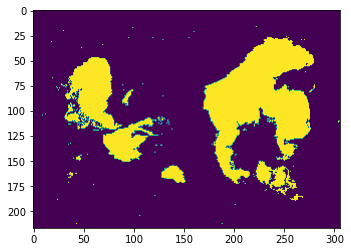

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
2.0
0.0
0.0
0.0
2.0
0.0
2.0
0.0
2.0
0.0
0.0
0.0
49.0
96.0
14.0
0.0
0.0
0.0
0.0
1.0
46.0
16.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
85.0
279.0
289.0
257.0
60.0
0.0
0.0
1.0
135.0
286.0
150.0
0.0
0.0
0.0
0.0
0.0
0.0
83.0
271.0
289.0
229.0
132.0
30.0
0.0
0.0
16.0
222.0
289.0
174.0
25.0
1.0
0.0
0.0
0.0
190.0
287.0
289.0
289.0
157.0
74.0
12.0
0.0
0.0
4.0
161.0
289.0
102.0
45.0
0.0
1.0
0.0
1.0
268.0
289.0
289.0
275.0
289.0
289.0
43.0
0.0
2.0
13.0
146.0
187.0
204.0
59.0
115.0
31.0
1.0
0.0
147.0
286.0
193.0
96.0
250.0
289.0
58.0
3.0
1.0
0.0
2.0
6.0
201.0
274.0
135.0
12.0
0.0
0.0
76.0
247.0
14.0
0.0
194.0
172.0
15.0
0.0
0.0
0.0
20.0
1.0
94.0
233.0
44.0
1.0
0.0
0.0
69.0
189.0
0.0
15.0
100.0
49.0
0.0
0.0
0.0
0.0
18.0
0.0
0.0
0.0
0.0
74.0
184.0
0.0
3.0
197.0
87.0
217.0
163.0
8.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
0.0
0.0
1.0
16.0
0.0
0.0
10.0
4.0
32.0
116.0
56.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
14.0
0.0
0.

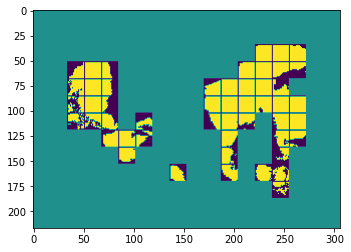

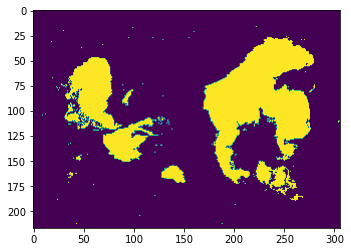

In [363]:
input_path = 'hxu_predictions-Jinhwan/tissue_mask/2747756_CR10-1140 A2_Tumor_HE.png'
tissue_mask_img=plt.imread(input_path)
R = tissue_mask_img[:,:,0]
# Grid lines at these intervals (in pixels)
# dx and dy can be different



# Custom (rgb) grid color
line_space=17
img=R.copy()
plt.imshow(img)
plt.show()
im=R.copy()
H, W = img.shape
img[0:H:line_space] = 0
img[:, 0:W:line_space] = 0

M=17; N=17
tiles = [im[x:x+M,y:y+N] for x in range(0,im.shape[0],M) for y in range(0,im.shape[1],N)]
i=0
for x in range(0,img.shape[0],M):
    for y in range(0,img.shape[1],N):
        print(tiles[i].sum())
        if (tiles[i].sum())<100:
            img[x:x+M,y:y+N]=0.5
        i+=1

plt.imshow(img)
plt.show()
plt.imshow(R)
plt.show()


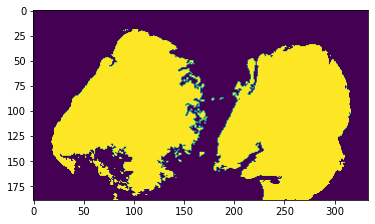

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 175.0, 191.0, 90.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 97.0, 256.0, 256.0, 256.0, 99.0, 5.0, 0.0, 0.0, 15.0, 85.0, 191.0, 240.0, 247.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 64.0, 247.0, 256.0, 256.0, 256.0, 227.0, 41.0, 0.0, 0.0, 84.0, 228.0, 256.0, 256.0, 256.0, 242.0, 16.0, 0.0, 0.0, 0.0, 23.0, 237.0, 256.0, 256.0, 256.0, 256.0, 231.0, 171.0, 0.0, 22.0, 166.0, 253.0, 256.0, 256.0, 256.0, 256.0, 103.0, 0.0, 0.0, 1.0, 213.0, 256.0, 256.0, 256.0, 256.0, 256.0, 255.0, 125.0, 7.0, 44.0, 255.0, 256.0, 256.0, 256.0, 256.0, 256.0, 146.0, 0.0, 0.0, 130.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 255.0, 161.0, 12.0, 167.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 115.0, 0.0, 0.0, 230.0, 256.0, 256.0, 250.0, 256.0, 256.0, 256.0, 246.0, 134.0, 28.0, 256.0, 256.0, 239.0, 256.0, 256.0, 256.0, 245.0, 8.0, 0.0, 0.0, 172.0, 142.0, 94.0,

In [364]:
sum_pix=[]
input_path = 'hxu_predictions-Jinhwan/tissue_mask/1664369_MR16-1693 J3_Tumor_HE.png'
tissue_mask_img=plt.imread(input_path)
R = tissue_mask_img[:,:,0]
# Grid lines at these intervals (in pixels)
# dx and dy can be different



# Custom (rgb) grid color
line_space=17
img=R
plt.imshow(img)
plt.show()
im=R
H, W = img.shape
img[0:H:line_space] = 0
img[:, 0:W:line_space] = 0

M=17; N=17
tiles = [im[x:x+M,y:y+N] for x in range(0,im.shape[0],M) for y in range(0,im.shape[1],N)]

from matplotlib.pyplot import cm
        
for i in range(len(tiles)):
    sum_pix.append(tiles[i].sum())
print(sum_pix)


In [376]:
import pandas as pd
df_p=pd.read_excel(io='2022-04-19 TILs Analysis Spreadsheet.xlsx')
df_p.head()

df_a=pd.read_csv('result_Tumor_tils_density_test.csv')
df_a.rename(columns={'file_name':'MRN'}, inplace=True)
df_a.head()



,MRN,immune_infl,immune_excl,immune_des
0,1664369,0.585859,0.080808,0.333333
1,2305194,0.389610,0.272727,0.337662
2,2332894,0.418605,0.395349,0.186047
3,2339093,0.452381,0.357143,0.190476
4,2369433,1.000000,0.000000,0.000000


In [377]:
df_m=pd.merge(df_p,df_a)
df_m.columns

Index(['MRN', 'REDCap ID', 'Match ID (Used to Link Cases and Controls)',
       'Pathology Accession Number', 'Case (1=Y)',
       'Years to Progression or Last Follow-up', 'Age at Surgery in Years',
       'Male Sex (1=Y)', 'Overall ACE-27 Score', 'Pack-years >10 (1=Y)',
       'AJCC 8th Edition Pathologic Overall Stage', 'Primary Management',
       'Primary Tumor Tumoral TILs Density',
       'Primary Tumor Stromal TILs Density',
       'Primary Tumor Pattern of Invasion', 'Lymph Node Tumoral TILs Density',
       'Lymph Node Stromal TILs Density', 'PR IHC CD3 (1=Y)',
       'PR IHC FoxP3 (1=Y)', 'PR IHC CD4 (1=Y)', 'PR IHC CD8 (1=Y)',
       'PR IHC KRT AE1AE3 (1=Y)', 'PR IHC CD163 (1=Y)', 'PR IHC PDL1 (1=Y)',
       'PR IHC ERalpha (1=Y)', 'PR IHC ERbeta (1=Y)', 'PR IHC CD20 (1=Y)',
       'PR IHC CD45 (1=Y)', 'PR H&E (1=Y)', 'LN IHC CD3 (1=Y)',
       'LN IHC FoxP3 (1=Y)', 'LN IHC CD4 (1=Y)', 'LN IHC CD8 (1=Y)',
       'LN IHC KRT AE1AE3 (1=Y)', 'LN IHC CD163 (1=Y)', 'LN IHC PDL1

In [378]:
df_ext=df_m[["MRN","Primary Tumor Tumoral TILs Density","immune_infl","immune_excl","immune_des","Years to Progression or Last Follow-up","Case (1=Y)"]]
df = pd.DataFrame(
   {
      "MRN": [],
      "Immune_ph": []
   }
)
for i,row in enumerate(df_ext.iterrows()):
    if row[1]["immune_infl"]>0.33:
        df.loc[i]=[row[1]["MRN"], "immune_inflamed"]
    elif row[1]["immune_excl"]>0.33:
        df.loc[i]=[row[1]["MRN"], "immune_excluded"]
    else:
        df.loc[i]=[row[1]["MRN"], "immune_desert"]
        
        
    

In [379]:
df_ph=pd.merge(df_ext,df)

df_ph.rename(columns={'Case (1=Y)':'Case'}, inplace=True)
print(df_ph.head())
df_ph.to_csv('Immune_pheno.csv')

       MRN Primary Tumor Tumoral TILs Density  immune_infl  immune_excl  \
0  1664369                               <10%     0.585859     0.080808   
1  2305194                               <10%     0.389610     0.272727   
2  2332894                             10-39%     0.418605     0.395349   
3  2339093                               <10%     0.452381     0.357143   
4  2369433                             10-39%     1.000000     0.000000   

   immune_des  Years to Progression or Last Follow-up  Case        Immune_ph  
0    0.333333                                3.441478     0  immune_inflamed  
1    0.337662                                5.292266     0  immune_inflamed  
2    0.186047                                0.585900     1  immune_inflamed  
3    0.190476                                1.023956     1  immune_inflamed  
4    0.000000                               10.236824     0  immune_inflamed  


In [359]:
0.26*134320

34923.200000000004

In [ ]:
3.4*1e-4